Report Assigment 1 names...

In this first assigment we want to explore and understand the HBV0001a model. Our goal is to fit the model to the actual discharge of the catchment Schenkenau, Bavaria. To do so, we will find the optimal parameters using the differential evolution method already implemented in Scipy, make physical sense of the results and turn different modules off to truly understand the model.

The HBV001 model ist a conceptual model. We will use the lumped version of it. It consist of 4 main modules:
1. Snow module. 

   The snow module models snow melt and the change of the snow depth for a given precipitation in the catchment. Parameteres to take into account are the threshold temperature (TT) being the temperature at wich the snow begins to melt if the temperature is above it, the degree-day (AMF), which amplifies the melting and the rain on snow (PMF) parameter.
   In formula, the HBV0001 models the melt as follows:
   $$ MLT = \begin{cases}
    (TEM - TT) \times (AMF + (PPT \times PMF)), & \text{if } TEM > TT \\
    0, & \text{else}
    \end{cases} 
   $$
   Once the melt is computed, for mass conservation, one has to update the melt as the minimum of snow depth and melt. Moreover, melt increases the potential runoff. Thus this has to be updated as well.
   $$
    MLT = \text{MIN}(SNW_{DTH}, MLT)
   $$
   $$
    RNF_{POT} = \begin{cases}
    MLT + PPT, & \text{if } TEM > TT \\
    0, & \text{else}
    \end{cases}
    $$
   Finallys, melt decreases the snow depth and precipitation increases it, given that the temperature is under TT. So for mass conservation and physical interpretability, one has to update the snow depth, too. 
   $$
    SNW_{DTH} = \begin{cases}
    SNW_{DTH} - MLT, & \text{if } TEM > TT \\
    SNW_{DTH} + PPT, & \text{else}
    \end{cases}
   $$
   This completes the snow module. The water will infiltrate on various ways the soil.

   Before continuing with the soil module we will briefly discuss theoretically, how to 'turn the snow module off'. First, setting TT to a very low temperature which will never occur, e.g. -100 degree Celsius will always lead to melt Consequently, the snow depth will always be smaller than the computed melt and thus in the final update, snow_depth will be equal to zero. Anothe roption is too set the parametrs AMF and PMF equal to zero as then no melt occurs at all.

2. Soil module
   The soil module controls infiltration, evapotranspiration reduction, storage and percolation to the upper reservoir.
   $$
   RNF = \left(\frac{SOL_{DTH}}{FCY}\right)^{\beta}\times RNF_{POT},\qquad 
   $$
   $$
   ILN = RNF_{POT} - RNF,\qquad 
   $$
   $$
   SOL_{DTH} \leftarrow SOL_{DTH} + ILN, \qquad 
   $$
   $$
   RNF \leftarrow RNF + \max(SOL_{DTH} - FCY,\, 0), \qquad 
   $$
   $$
   SOL_{DTH} \leftarrow \min(SOL_{DTH},\, FCY),\qquad 
   $$
   $$
   ILN \leftarrow RNF_{POT} - RNF
   $$
   $$
   ETN = \frac{SOL_{DTH}}{PWP} \times PET, \qquad 
   $$
   $$
   ETN = \min(ETN,\, SOL_{DTH}) \qquad 
   $$
   $$
   SOL_{DTH} \leftarrow SOL_{DTH} - ETN, \qquad 
   $$

3. Upper reservoir
   The URR receives percolation from soil and possibly a share of surface inputs. It can generate a quick flow (QT) component and send percolation to LRR.
   $$
   URR_{DTH} \leftarrow URR_{DTH} + \left( (1 - WSR) \times RNF \right)
   $$
   $$
   Q_T = (URR_{DTH} - URR_{TDH}) \times TDR, \qquad Q_T = \max(Q_T,\, 0)
   $$
   $$
   URR_{DTH} \leftarrow URR_{DTH} - Q_T 
   $$
   $$
   Q_N = \min(URR_{DTH},\, URR_{TDH}) \times NDR, \qquad URR_{DTH} \leftarrow URR_{DTH} - Q_N 
   $$
   $$
   PLN = URR_{DTH} \times ULC, \qquad URR_{DTH} \leftarrow URR_{DTH} - PLN
   $$

4. Lower reservoir
   $$
   Q_L = LRR_{DTH} \times DRE,
   $$
   $$
   LRR_{DTH} \leftarrow LRR_{DTH} - Q_L
   $$
   $$
   LRR_{DTH} \leftarrow LRR_{DTH} + PLN 
   $$



After introducing the model theoretically, we want to run and optimize it, interpret the results and discuss what happens if some modules are turned off. 

As already mentionned in the introduction, we want to optimize the model to fit the observed discharge in Schenkenau.
To do so, we have to define an objective function over which we can optimize. We choose the Nash-Sutcliff-Efficiency
$$
NSE = 1 - \frac{\sum_{i} (OBS_{i} - SIM_{i})^2}{\sum_{i} (OBS_{i} - \bar{OBS})^2}
$$
We can implement this in Python:

In [ ]:
def calc_nse(obs: np.ndarray, sim: np.ndarray) -> float:
    """Compute NSE."""
    obs = np.asarray(obs, float)
    sim = np.asarray(sim, float)
    mask = np.isfinite(obs) & np.isfinite(sim)
    obs = obs[mask]; sim = sim[mask]
    denom = np.sum((obs - obs.mean()) ** 2)
    if denom <= 0:
        return float("-inf")
    return 1.0 - np.sum((obs - sim) ** 2) / denom


In the objective value itself we want to maximize the NSE, that is we want to minimize 1-NSE

In [ ]:
def objective_function(params, model,diso): #model is initialized HBV0001 model
    """Clamp params, run model, return (ofv=1-NSE, {'NSE': nse}, sim)."""
    p = np.asarray(params, float).copy()
    for i, (lo, hi) in enumerate(BOUNDS):
        p[i] = np.clip(p[i], lo, hi) # Clamp to bounds
    try:
        model.set_parameters(p) # set the model parameters to the initialized model
    except AssertionError:
        return 1e6, {"NSE": float("-inf")}, None  
    model.run_model()
    sim = model.get_discharge() # simulate the discharge
    nse = calc_nse(diso, sim) # calculate the NSE between observed and simulated discharge
    ofv = 1.0 - nse if np.isfinite(nse) else 1e6
    return ofv, {"NSE": float(nse)}, sim

Given this objective function, we can try to get the simulated discharge to fit the observed discharge being close to 1.

To do so, an optimization scheme to find the best parameter vector. is required. Recall that the parametrs are:


In [ ]:
PARAM_NAMES = [
    "snw_dth","snw_att","snw_pmf","snw_amf",
    "sl0_dth","sl0_pwp","sl0_fcy","sl0_bt0",
    "urr_dth","lrr_dth",
    "urr_wsr","urr_ulc","urr_tdh","urr_tdr","urr_ndr","urr_uct",
    "lrr_dre","lrr_lct"
]

We implemented the predefined differential evolution from scipy. First we have to initialize containers, which will save the parameters, the objective function value, the best parameters by generation and the best NSE atfer each iteration. The differntial evolution scheme also requires bounds of each parameter to sample from randomly. This was also defined. Next, we define the required inputs for the differntial evolution function. 

The two following functions are crusial:
1. recorded_ofv 

Purpose: wrapper used as the objective handed to scipy.optimize.differential_evolution.
What it does:
Calls objective_function(x, m0, diso) to get ofv, metrics, sim.
Appends parameters and ofv to eval_params and eval_ofv lists.
Computes a coarse generation index and writes a row into eval_log.
Increments eval_idx and returns the scalar ofv to DE.

2. de_callback

Purpose: called by DE at the end of each generation with the current best candidate xk and a convergence value.
What it does:
Stops DE early if wall-clock time or eval budget exceeded.
Re-evaluates objective_function(xk, m0, diso) (this re-runs the model for the current best).
Appends current best ofv/params to best_by_gen, best_params_by_gen and best_nse_by_gen.
Updates best_solution if improved and prints status.
Returns False to continue (or True to stop).

Finally, we defined the differential_evolution with our input. Note that we do not want an extra gradient based optimization at the end, hence we set the parameter polish = False in the function call. We save the outputs for fruther plottings.

In [ ]:
    # Logging containers 
    BOUNDS = [
    (0.00, 0.00),   # snw_dth  (fixed 0)
    (-2.0, 3.0),    # snw_att
    (0.00, 3.00),   # snw_pmf
    (0.00, 10.0),   # snw_amf

    (0.00, 100.0),  # sl0_dth
    (5.00, 700.0),  # sl0_pwp
    (100.0, 700.0), # sl0_fcy
    (0.01, 10.0),   # sl0_bt0

    (0.00, 20.0),   # urr_dth
    (0.00, 100.0),  # lrr_dth

    (0.00, 1.00),   # urr_wsr
    (0.00, 1.00),   # urr_ulc
    (0.00, 200.0),  # urr_tdh
    (0.01, 1.00),   # urr_tdr
    (0.00, 1.00),   # urr_ndr
    (0.00, 1.00),   # urr_uct

    (0.00, 1.00),   # lrr_dre
    (0.00, 1.00),   # lrr_lct
    ]

    prms0 = np.array([
                0.00, 0.10, 0.01, 0.10,
                0.00, 300., 70.,  2.50,
                0.00, 0.00,
                1.00, 0.01, 30., 0.10, 0.10, 0.01,
                1e-3, 1e-5
            ], dtype=float)

    eval_params, eval_ofv = [], []
    eval_log = []                 # every evaluation row
    best_by_gen = []
    best_params_by_gen = []
    best_nse_by_gen = []

    # Best-so-far snapshot
    best_solution = {"params": None, "ofv": np.inf, "metrics": None}

    #  DE settings 
    popsize = 6
    n_params = len(BOUNDS)
    pop_n = popsize * n_params         # approx trials per generation
    eval_idx = 0
    start_time = time.time()

    def recorded_ofv(x):
        nonlocal eval_idx
        ofv, metrics, _ = objective_function(x, m0, diso)
        eval_params.append(np.array(x, float))
        eval_ofv.append(float(ofv))
        # use popsize (evaluations per generation) instead of popsize * n_params
        generation = eval_idx // popsize
        row = {
            "eval_idx": eval_idx,
            "generation": generation,
            "ofv": float(ofv),
            "nse": float(metrics["NSE"]),
        }
        row.update({name: float(val) for name, val in zip(PARAM_NAMES, x)})
        eval_log.append(row)
        eval_idx += 1
        return ofv

    def de_callback(xk, convergence):
        # Stop on time or eval budget 
        elapsed_min = (time.time() - start_time) / 60.0
        if elapsed_min >= max_minutes or eval_idx >= max_evals:
           print(f"\n Stopping early: elapsed={elapsed_min:.2f} min, evals={eval_idx}")
           return True  # stop DE

         # Use last recorded evaluation for current best (avoid re-eval)
        if eval_ofv:
            ofv = eval_ofv[-1]
            best_params_by_gen.append(np.array(xk, float))
            best_by_gen.append(ofv)
            # try to recover NSE from eval_log last row
            best_nse_by_gen.append(eval_log[-1].get("nse", float("-inf")))
        else:
            # fallback: do a single evaluation (rare at start)
            ofv, metrics, _ = objective_function(xk, m0, diso)
            best_by_gen.append(ofv)
            best_params_by_gen.append(np.array(xk, float))
            best_nse_by_gen.append(float(metrics["NSE"]))

        if ofv < best_solution["ofv"]:
            best_solution["params"] = np.array(xk, float)
            best_solution["ofv"] = ofv
            # metrics may be unavailable here if we didn't re-eval; keep None-safe
            best_solution["metrics"] = {"NSE": best_nse_by_gen[-1]}
            print(f"\n New best! Gen {len(best_by_gen)}: OFV={ofv:.4f}, NSE={best_solution['metrics']['NSE']:.4f}")

        print(f"Gen {len(best_by_gen):3d} | best (1-NSE) = {ofv:.6f}")
        return False

    res = differential_evolution(
        recorded_ofv,
        bounds=BOUNDS,
        strategy="best1bin",
        maxiter=1000,                 # high cap; budget guard stops earlier
        popsize=popsize,
        tol=1e-4,
        mutation=(0.5, 1.0),
        recombination=0.7,
        seed=42,
        callback=de_callback,
        #polish=True,
        updating="deferred",
        #workers=-1,
        atol = 1e-3,
        polish = False
    )
    # Final evaluation at DE-returned best
    best_params = res.x
    best_ofv, best_metrics, best_sim = objective_function(best_params, m0, diso)
    print("\nOptimization complete.")

    # Prefer callback best; fallback to res.x
    save_params = best_solution["params"] if best_solution["params"] is not None else best_params
    save_ofv = best_solution["ofv"] if np.isfinite(best_solution["ofv"]) else best_ofv
    save_metrics = best_solution["metrics"] if best_solution["metrics"] is not None else best_metrics

    # Save best
    np.savetxt("best_params.txt", save_params, fmt="%.6f")
    with open("best_metrics.txt", "w") as f:
        f.write(f"Best OFV (1-NSE): {save_ofv:.6f}\n")
        f.write(f"NSE: {save_metrics['NSE']:.4f}\n")

    # Save ALL evaluations table
    pd.DataFrame(eval_log).to_csv("de_eval_log.csv", index=False)


# Result and interpretation of the optimization

Note that the optimization was done in another script. The purpose of this report is to discuss the key ideas of implemetation as done above and then to interpret the results.

After running the optimization we obtain the following:

Best objective (1 - NSE): 0.098931

Best-fit NSE: 0.9011

param_vector: 

0.000000 "snw_dth"

0.148940 "snw_att"

0.634415 "snw_pmf"

0.036731 "snw_amf"

94.568525 "sl0_dth"

432.979200 "sl0_pwp"

148.866130 "sl0_fcy"

2.659653 "sl0_bt0"
    
1.728010 "urr_dth"

0.739939 "lrr_dth"

0.748241 "urr_wsr"

0.185272 "urr_ulc"

60.579322 "urr_tdh"

0.143289 "urr_tdr"

0.000401 "urr_ndr"

0.000147 "urr_uct"

0.008535 "lrr_dre"

0.000024 "lrr_lct"

and the following simulated discharge 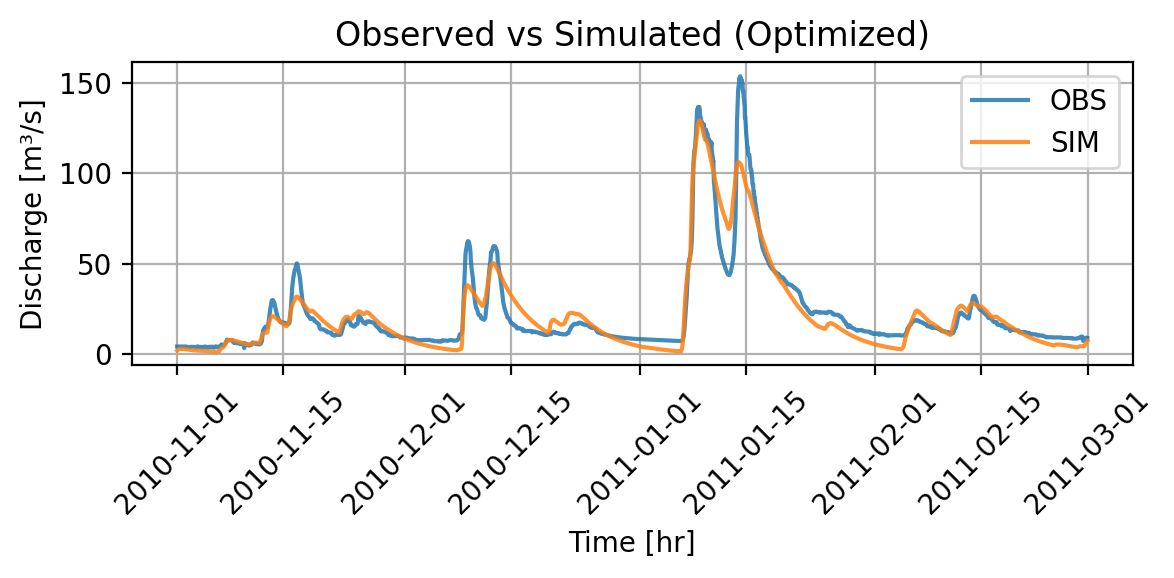


For the objective function value convergence 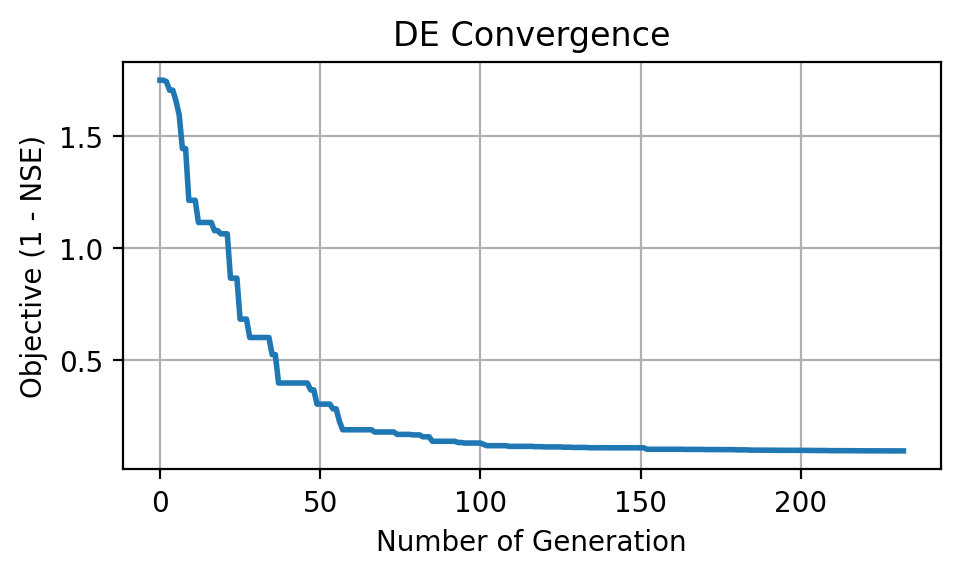

Around 100 generations in the differential evolution we observe no significant improvement.

# 1.Snow module

First we want to take the snow module out of our model. As described previously we take a very small TT and set AMF = PMF = 0. In the opitimization, we set the bounds to be constant. For the code see script "snow_off".

What do we expect?
From the optimization with all modules we obtained the following parameters:

0.148940 "snw_att"

0.634415 "snw_pmf"

0.036731 "snw_amf"

From this we can conclude that setting the amf equal to zero won't have a huge effect but doing so with the pmf will have a huge impact. Furthermore considering that we are in Bavaria were snow and melt plays an non neglictable role in the water cycle, one would expect a worse simulation of the discharge resulting in a smaller NSE and larger OFV. Moreover, in cold months one would expect the simulation to be less peaky as the melt implying higher runoff is neglected.

Running the code gives us:

Best objective (1 - NSE): 0.415265

Best-fit NSE: 0.5847

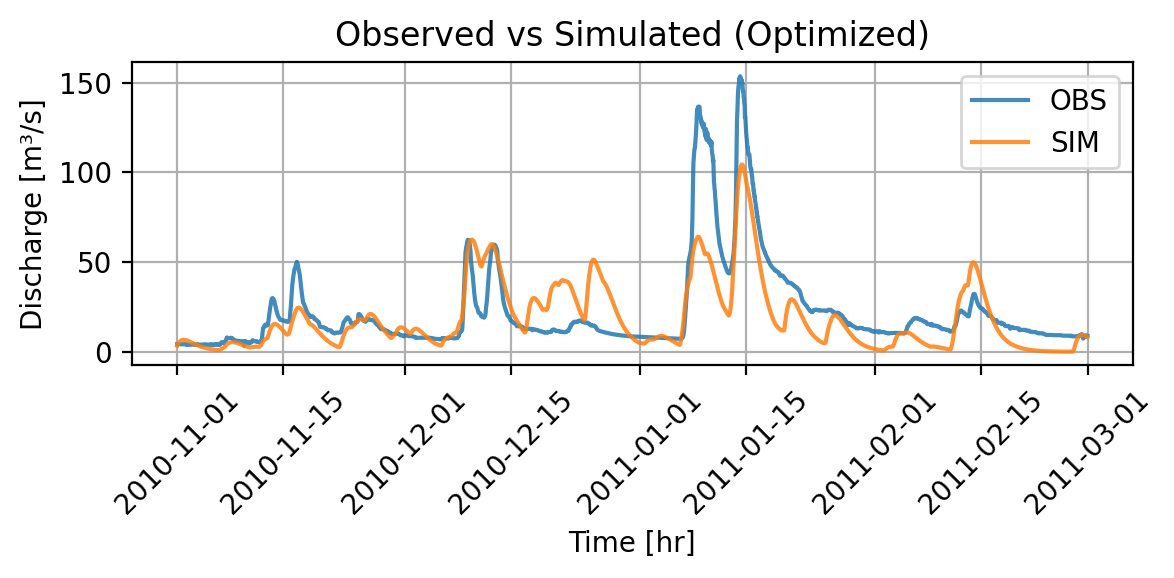

On observes a poor fit. The simulated discharge is as expected less peaky and do not capture the relative rapid discharge change, e.g. around 2010-12-01. This seems plausible as it is a cold month were melt can increase the final discharge and rapidly fall once the snow depth is minimal again. We only have the Precipitation taking into account.
The convergence plot looks good at first sight but taking a second look at the y axis shows a rather bad OFV, which is also displayed. Moreover, it never reaches a constant level, implying poor convergence.
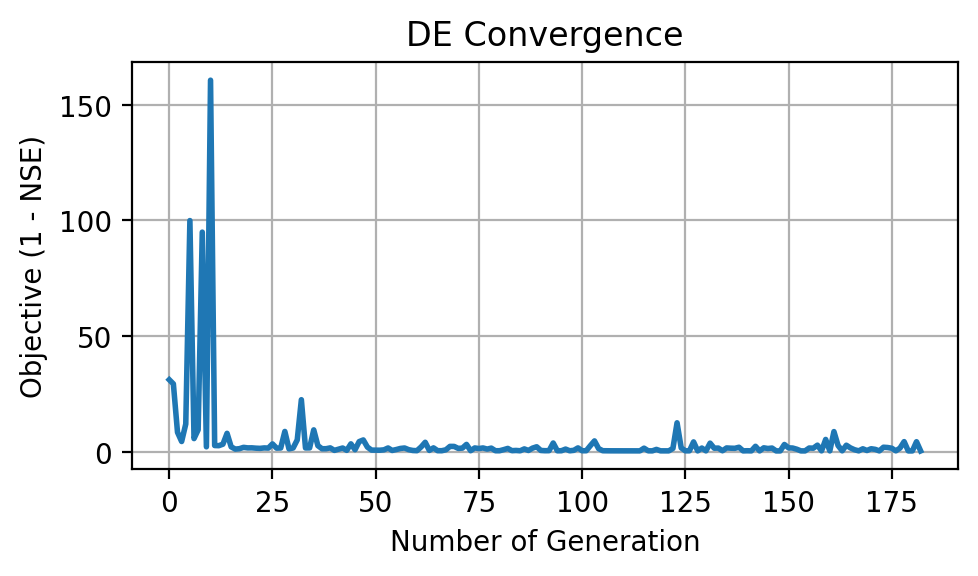

Our parameter vector is given by:
0.000000
-100.000000
0.000000
0.000000
96.085948
621.587668
191.547150
3.554228
1.465764
0.392804
0.911128
0.049866
63.548178
0.802290
0.000187
0.000022
0.026593
0.000001

# 2. Soil module

In [ ]:
Next, we want to turn off the soil module. For this the evapotranspiration and the infiltration have to be set to zero. This can be achieved by  
having the entirety of the potential runoff be the actualised runoff. Setting beta to zero will multiply the runoof potential with one and thus  
trigger the wanted result. To turn off the evapotranspiration the initial soil moisture should be set to zero. One can also give the permanent   
wilting point a very high value to achieve a similar result. For comparison, these were the optimised values:  

94.568525 "sl0_dth"

432.979200 "sl0_pwp"

148.866130 "sl0_fcy"

2.659653 "sl0_bt0"

One can see, that every value will change quite a bit and thus a much more different result is to be expected. This can be explained by the big impact,
which plants have on the water balance in this case, because we are in Bavaria, where there is plenty of vegetation. The soil itself also seems to 
absorb a non negligible amount of water. The results of running this module off are the following:

An objective value of 0.157

A NSE of 0.843

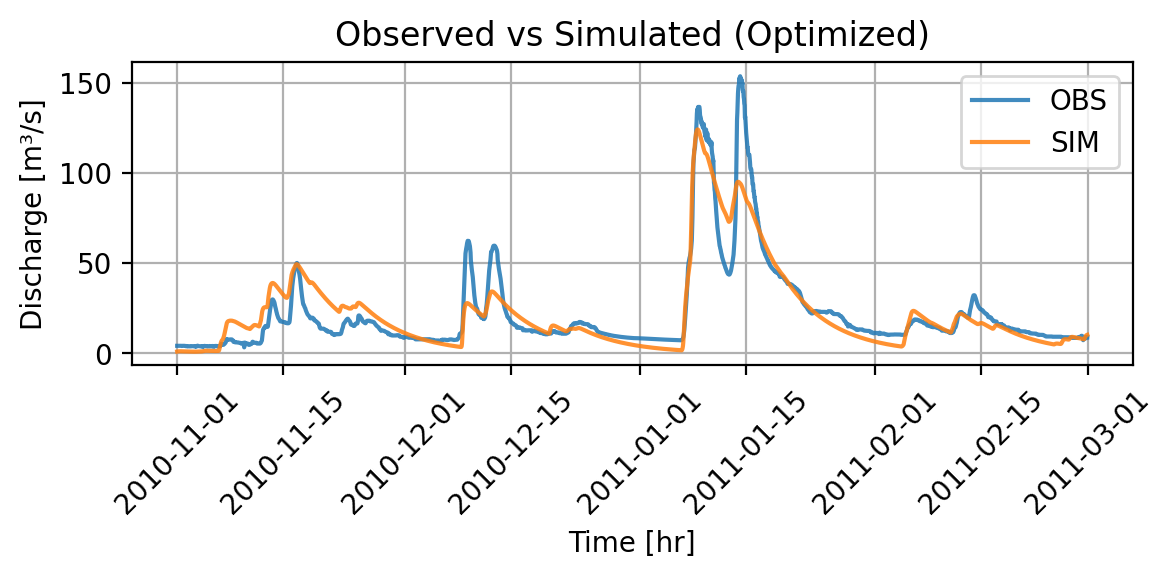

In [ ]:
The graph shows bigger errors in the simulation for the peaks and a slow approachment of the simulation towards the obeserved discharge afterwards,
while even undershooting it after a while. This reoccuring theme seems to stem from the fact, that no water is infiltrating the soil and thus has to 
runoff immediately, which leaves less water to runoff in the lon run, thus creating this undershoot effect.

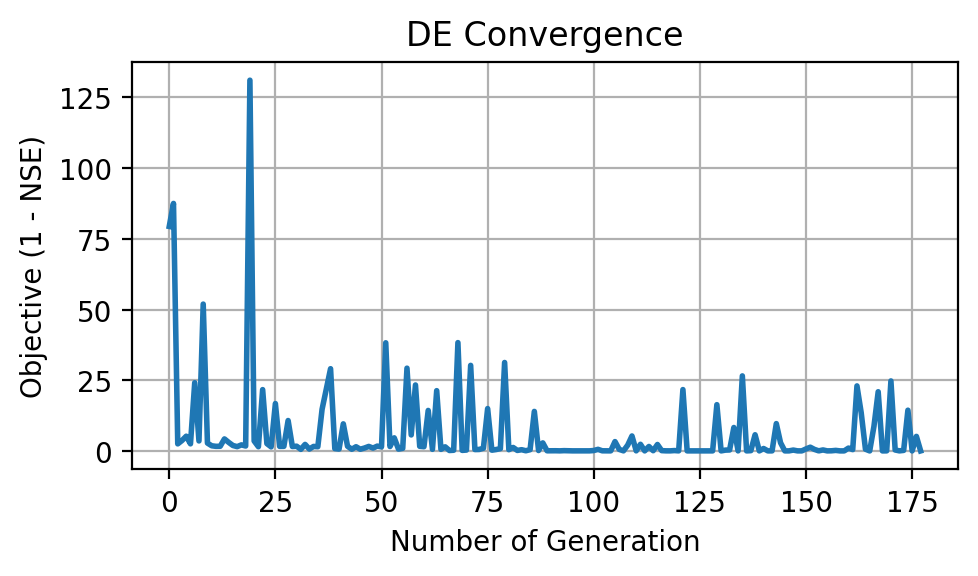

In [ ]:
Indeed, like expected, the convergence is less than optimal. The decent NSE and resulting objective function value seem to be a fluke. The graph 
seems to approach 0 several times, but quickly deteriorate quickly afterwards. It can be therefore assumed, that turning off the soil module will 
result in a bad simulation. Finally, the optimised values for the parameters:
0.000000
1.209218
1.277700
0.115713
0.000000
1000000.000000
0.000001
0.000000
0.303784
0.120041
0.848500
0.192323
128.334607
0.740068
0.000190
0.010203
0.005468
0.000916